In [1]:
!pip install nltk

In [20]:
import pandas as pd
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [23]:
LTC_BINARY = '../data/ltc_matrices/ltc_matrix_binary_mm4.tsv'

#print(os.listdir('Data/ltc_matrices'))

ltc_patients = pd.read_csv(LTC_BINARY, sep = '\t')

ltc_patients.head(5)


patient_id  dermatitis  erectile_dysfunction  OA  pri_skin  skin_ulcer  \
0     1000059           1                     1   1         1           1   
1     1000062           0                     0   0         0           0   
2     1000077           0                     0   0         1           0   
3     1000124           0                     0   1         0           0   
4     1000146           0                     0   1         1           0   

   female_genital_prolapse  fracture_hip  obesity  spondylosis  ...  \
0                        0             0        0            0  ...   
1                        1             1        1            1  ...   
2                        0             0        0            0  ...   
3                        0             0        0            0  ...   
4                        0             0        0            0  ...   

   cerebral_palsy  pri_mesothelioma  pri_brain  thala  sick_sinus  ADHD  \
0               0                 0          0      0           0     0   
1               0                 0          0      0           0     0   
2               0                 0          0      0           0     0   
3               0                 0          0      0           0     0   
4               0                 0          0      0           0     0   

   juv_arth  downs  entero_arthro  SARS_CoV2  
0         0      0              0          0  
1         0      0              0          0  
2         0      0              0          0  
3         0      0              0          0  
4         0      0              0          0  

[5 rows x 204 columns]

In [4]:
dictionary_of_patients = []

patients = ltc_patients['patient_id'].unique()
ltcs = ltc_patients.drop('patient_id', axis = 1)
index = 0

#Iterate through patients
for patient in patients:
    
    #Start with empty list of LTCs for each patient
    patient_ltcs = []
    
    #Iterate through each LTC for patient
    for ltc in ltcs:
        
        #Check if patient has LTC
        if ltc_patients.at[index, ltc] == 1:
            
            #If LTC present, add to list of patient LTCs
            patient_ltcs.append(ltc)   
    
    #Add list of patient LTCs to list of patients        
    dictionary_of_patients.append(patient_ltcs)
    
    #Increment index by 1
    index+=1

In [26]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(dictionary_of_patients[0:5])
pp.pprint("Documents in corpus: {l}".format(l=len(dictionary_of_patients)))

[   ['dermatitis', 'erectile_dysfunction', 'OA', 'pri_skin', 'skin_ulcer'],
    [   'female_genital_prolapse',
        'fracture_hip',
        'obesity',
        'spondylosis',
        'type_2_diabetes',
        'unspecified_rare_diabetes',
        'urine_incont'],
    [   'pri_skin',
        'allergic_rhinitis',
        'atrial_fibrilation',
        'cholelithiasis',
        'CKD',
        'cystic_renal',
        'enthesopathy',
        'epilepsy',
        'ESRD',
        'gout',
        'hearing_loss',
        'hypertension',
        'pri_other',
        'thyroid',
        'venous_thromb'],
    [   'OA',
        'enthesopathy',
        'hypertension',
        'thyroid',
        'constipation_read',
        'depression',
        'intervert_disc',
        'menorrhagia'],
    ['OA', 'pri_skin', 'enthesopathy', 'CCD']]
'Documents in corpus: 143168'


In [6]:
id2word = corpora.Dictionary(dictionary_of_patients)

corpus = []
for text in dictionary_of_patients:
    new = id2word.doc2bow(text)
    corpus.append(new)

In [25]:
print(corpus[143160][0:20])
print(id2word[202])

[(0, 1), (2, 1), (3, 1), (7, 1), (9, 1), (10, 1), (22, 1), (27, 1), (31, 1), (35, 1), (36, 1), (43, 1), (68, 1), (72, 1), (74, 1), (78, 1), (84, 1), (107, 1), (120, 1)]
SARS_CoV2


In [34]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="symmetric")


In [35]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.194*"oth_anaemia" + 0.146*"gout" + 0.139*"iron_deficiency_anaemia" '
        '+ 0.126*"psoriasis" + 0.078*"vitb12_deficiency" + '
        '0.074*"neuro_bladder" + 0.051*"CKD" + 0.045*"heart_failure" + '
        '0.025*"atrial_fibrilation" + 0.020*"autonomic_neuro"'),
    (   1,
        '0.178*"type_2_diabetes" + 0.123*"hypertension" + '
        '0.109*"unspecified_rare_diabetes" + 0.108*"CKD" + 0.076*"obesity" + '
        '0.075*"diab_eye" + 0.045*"erectile_dysfunction" + 0.032*"RhA" + '
        '0.026*"OA" + 0.025*"fibromyalgia"'),
    (   2,
        '0.065*"dermatitis" + 0.064*"enthesopathy" + 0.064*"hypertension" + '
        '0.063*"OA" + 0.044*"depression" + 0.040*"alcohol_depend" + '
        '0.037*"venous_lymphatic" + 0.035*"GORD" + 0.034*"hearing_loss" + '
        '0.033*"diverticular"'),
    (   3,
        '0.074*"CHD" + 0.069*"hypertension" + 0.062*"erectile_dysfunction" + '
        '0.052*"enthesopathy" + 0.044*"OA" + 0.042*"BPH" + '
        '0.038*"hear

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis


G:\anacondapy3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.227561  0.232413       1        1  37.461841
2     -0.151454  0.073891       2        1  22.510872
3     -0.335300 -0.045511       3        1  19.296766
1      0.179504  0.321126       4        1   9.669374
0      0.472835 -0.084169       5        1   7.014724
5      0.061977 -0.497750       6        1   4.046422, topic_info=                Term          Freq         Total Category  logprob  loglift
9    type_2_diabetes  18985.000000  18985.000000  Default  30.0000  30.0000
96       oth_anaemia  15000.000000  15000.000000  Default  29.0000  29.0000
60         sinusitis  34408.000000  34408.000000  Default  28.0000  28.0000
22      hypertension  55281.000000  55281.000000  Default  27.0000  27.0000
20              gout  11296.000000  11296.000000  Default  26.0000  26.0000
..               ...           ...           ...      ...      ...      ...
108  aortic_aneurysm      0.297181    925.024887   Topic6 -11.9210  -4.8359
155              GCA      0.297011    543.461225   Topic6 -11.9216  -4.3046
13              ESRD      0.296071    552.541477   Topic6 -11.9247  -4.3243
59        pri_kidney      0.295218    469.223883   Topic6 -11.9276  -4.1638
44        somatoform      0.294844   8273.363118   Topic6 -11.9289  -7.0348

[297 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
128       3  0.999344                BAD
33        3  0.999841                BPH
30        2  0.999531                CCD
56        3  0.999913                CHD
12        4  0.745850                CKD
...     ...       ...                ...
81        2  0.552976   venous_lymphatic
25        2  0.748647      venous_thromb
25        3  0.251356      venous_thromb
50        5  0.999822  vitb12_deficiency
135       3  0.998426           vitiligo

[256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1, 6])

In [40]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=dictionary_of_patients):
    
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                
                wp = ldamodel.show_topic(topic_num)
                
                topic_keywords = ", ".join([word for word, prop in wp])
                
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=dictionary_of_patients)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.5903   
1            1             4.0              0.5519   
2            2             3.0              0.4693   
3            3             4.0              0.9068   
4            4             2.0              0.8329   
5            5             4.0              0.8318   
6            6             1.0              0.4656   
7            7             3.0              0.5368   
8            8             2.0              0.4309   
9            9             4.0              0.8608   

                                            Keywords  \
0  dermatitis, enthesopathy, hypertension, OA, de...   
1  sinusitis, allergic_rhinitis, depression, enth...   
2  CHD, hypertension, erectile_dysfunction, enthe...   
3  sinusitis, allergic_rhinitis, depression, enth...   
4  dermatitis, enthesopathy, hypertension, OA, de...   
5  sinusitis, allergic_rhinitis, depression, enth...   
6  type_2_diabetes, hypertension, unspecified_rar...   
7  CHD, hypertension, erectile_dysfunction, enthe...   
8  dermatitis, enthesopathy, hypertension, OA, de...   
9  sinusitis, allergic_rhinitis, depression, enth...   

                                                Text  
0  [dermatitis, erectile_dysfunction, OA, pri_ski...  
1  [female_genital_prolapse, fracture_hip, obesit...  
2  [pri_skin, allergic_rhinitis, atrial_fibrilati...  
3  [OA, enthesopathy, hypertension, thyroid, cons...  
4                  [OA, pri_skin, enthesopathy, CCD]  
5  [allergic_rhinitis, enthesopathy, hypertension...  
6  [erectile_dysfunction, type_2_diabetes, allerg...  
7  [erectile_dysfunction, pri_skin, type_2_diabet...  
8  [dermatitis, type_2_diabetes, enthesopathy, hy...  
9  [OA, allergic_rhinitis, menorrhagia, asthma, f...

In [108]:
df_dominant_topic.describe()

Document_No  Dominant_Topic  Topic_Perc_Contrib
count  143168.000000   143168.000000       143168.000000
mean    71583.500000        3.018573            0.612985
std     41329.186007        1.059345            0.171247
min         0.000000        0.000000            0.194400
25%     35791.750000        2.000000            0.475400
50%     71583.500000        3.000000            0.594300
75%    107375.250000        4.000000            0.761225
max    143167.000000        5.000000            0.958200

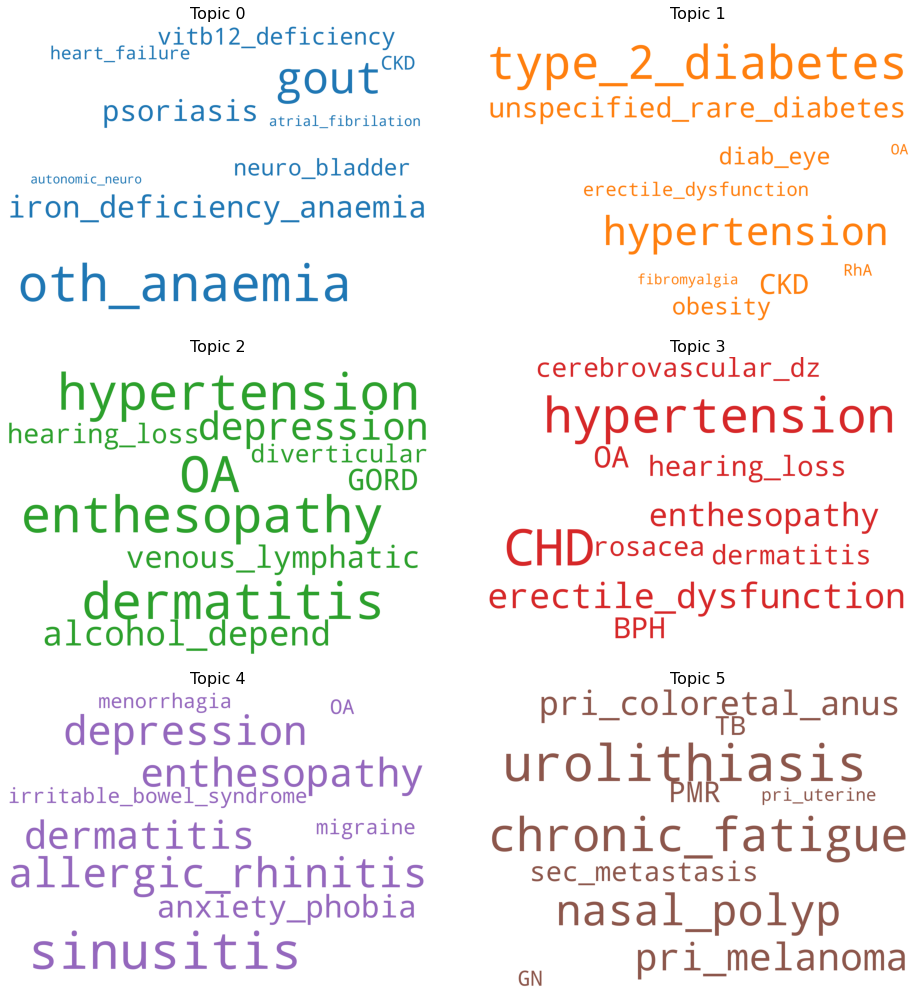

In [43]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(14,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [168]:
def GetKeyForSort(topic_list):
    return topic_list[1]

In [196]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


dominant_topic_weights = []

# Get topic weights
for i, row_list in enumerate(lda_model[corpus]):
    
    row_list.sort(reverse=True, key=GetKeyForSort)
    dominant_topic_weights.append(row_list[0])
    
    if i < 3:
        pp.pprint(i)
        pp.pprint(row_list)
        
for x in range(3):
        pp.pprint("Dominant Topics with Weights: {n}".format(n = dominant_topic_weights[x]))
        
# Array of topic weights    
arr = pd.DataFrame(dominant_topic_weights).fillna(0).values
for x in range(3):
        pp.pprint("Original Array of Topic Weights: {n}".format(n = arr[x]))

# # Keep the well separated points (optional)a
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = [x[0] for x in arr]
for x in range(3):
    pp.pprint("Dominant topic in each doc: {n}".format(n = topic_num[x]))

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=300, random_state=0, angle=.19, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot)

0
[   (2, 0.59008694),
    (3, 0.29844064),
    (1, 0.027978089),
    (4, 0.02793856),
    (0, 0.027777908),
    (5, 0.027777908)]
1
[   (4, 0.5518961),
    (1, 0.36445984),
    (2, 0.021057699),
    (3, 0.020918984),
    (0, 0.020833688),
    (5, 0.020833688)]
2
[   (3, 0.4693226),
    (2, 0.35305107),
    (0, 0.1460721),
    (1, 0.0106168715),
    (4, 0.010520298),
    (5, 0.010417055)]
'Dominant Topics with Weights: (2, 0.59008694)'
'Dominant Topics with Weights: (4, 0.5518961)'
'Dominant Topics with Weights: (3, 0.4693226)'
'Original Array of Topic Weights: [2.         0.59008694]'
'Original Array of Topic Weights: [4.        0.5518961]'
'Original Array of Topic Weights: [3.         0.46932259]'
'Dominant topic in each doc: 2.0'
'Dominant topic in each doc: 4.0'
'Dominant topic in each doc: 3.0'


Loading BokehJS ...

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [228]:
output_notebook()
n_topics = 6

topic_num = [x[0] for x in arr]
topic_num = [int(a) for a in topic_num]
for x in range(3):
    pp.pprint("Dominant topic in each doc: {n}".format(n = topic_num[x]))


mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda_x, y=tsne_lda_y, color=mycolors[topic_num])

show(plot)

Loading BokehJS ...

'Dominant topic in each doc: 2'
'Dominant topic in each doc: 4'
'Dominant topic in each doc: 3'


In [51]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==4].count()

Document_No           66016
Dominant_Topic        66016
Topic_Perc_Contrib    66016
Keywords              66016
Text                  66016
dtype: int64

In [226]:
tsne_lda_x = (tsne_lda[:,0])
tsne_lda_y = tsne_lda[:,1]
print(tsne_lda_x.shape)
print(tsne_lda_y)
print(tsne_lda.dtype)
print(topic_num)

(143168,)
[-5.0573707  17.071878   17.920626   ... -2.1749763  12.391753
  0.89678025]
float32
[2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 1.0, 3.0, 2.0, 4.0, 4.0, 1.0, 4.0, 1.0, 1.0, 2.0, 3.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 4.0, 4.0, 3.0, 3.0, 2.0, 4.0, 2.0, 3.0, 4.0, 3.0, 1.0, 2.0, 4.0, 3.0, 3.0, 1.0, 3.0, 2.0, 1.0, 1.0, 4.0, 2.0, 1.0, 4.0, 2.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 4.0, 4.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 4.0, 2.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 3.0, 2.0, 2.0, 4.0, 5.0, 2.0, 3.0, 4.0, 4.0, 3.0, 2.0, 3.0, 3.0, 3.0, 2.0, 4.0, 4.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 2.0, 4.0, 0.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 3.0, 4.0, 2.0, 3.0, 3.0, 4.0, 2.0, 4.0, 3.0, 4.0, 2.0, 3.0, 3.0, 4.0, 4.0, 2.0, 2.0, 3.0, 4.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0, 1.0, 4.0, 4.0, 5.0, 2.0, 4.0, 2.0, 4.0, 3.0, 2.0, 2.0, 1.0, 4.0, 4.0, 2.0,

In [194]:
def Func(e):
    return e[1]

test = []
test_dom_topic = []

for i, row_list in enumerate(lda_model[corpus]):
    if i < 5:
        row_list.sort(reverse=True, key = Func)
        test.append(row_list[0])
    else:
        break
test_dom_topic = [x[0] for x in test]    
print(test)
print(test_dom_topic)

[(2, 0.59082335), (4, 0.5519), (3, 0.46927598), (4, 0.90675455), (2, 0.832887)]
[2, 4, 3, 4, 2]
